# Total Dataset mining

In [1]:
import pandas as pd 
import numpy as np
from datetime import date,datetime
import csv
import re
from multiprocessing import Pool
from functools import partial
from sklearn import preprocessing
from IPython.core import display as ICD
import matplotlib.pyplot as plt
import itertools
import os

In [82]:
# TODO add doc 
def dataset_property_split(df,frequency,properties,min_support,groupby_property="CUST_ID",itemset_property="ARTICLE_ID",temp_folder="lcm_temp",indexation_folder="index"):
    """Split dataset """
    for period,i in df.groupby(pd.Grouper(freq = frequency)):
        for values,ii in i.groupby(properties):
            if len(properties)>1:
                values = '_'.join(str(z) for z in values)
            
            split_name = f"{temp_folder}/{period}_{values}#{min_support}"
            index_file_name = f"{indexation_folder}/{period}_{values}#{min_support}"

            ii = ii.groupby(groupby_property)[itemset_property].apply(lambda x: " ".join(str(z) for z in x))
            
            ii.to_csv(split_name,index=None,header=False)
            pd.DataFrame(ii.index).to_csv(index_file_name,header=False,index=None)
            yield str(split_name)
        
def reformat_output(unformated_result,split_name,index_folder="index"):
    """
    Reformat default output of lcm  to a dataframe with structure : min_support,itemsets,users
    """
    output = pd.DataFrame([unformated_result[0::2],unformated_result[1::2]]).T
    output = pd.concat([output.drop(0,axis=1),output[0].str.split('\(([0-9]+)\)',expand=True).drop(0,axis=1)],axis=1)
    split_name= split_name.split("/")[1] #remove temp folder from name

    output["period"] = split_name.split("_")[0]
    output["property_values"] = "_".join(split_name.split("_")[1:]).split("#")[0]
    output.columns = ["CUST_ID","support","itemset","period","property_values"]

    indexes = pd.read_csv(f'{index_folder}/{split_name}',header=None)[0].to_dict()
    output["CUST_ID"]= output["CUST_ID"].map(lambda x : [indexes[int(i)] for i in x.split()])
    
    return output


# TODO doc for support
def run_lcm(split_name,itemsets_size,support,output_file):
    """Runs LCM (Single Thread)  and return the  result formated with format_output
    
    Example for parameters : input_file='1999',support=6, itemsets_size=[5,100]
    Executed command :  $ ./lcm C_QI -l 5 -u 100 1999 6 -
    
    Preconfigured parameters:  
     C: enumerate closed frequent itemsets
     M: enumerate maximal frequent itemsets 
     Q: output the frequency on the head of each itemset found,
     I: output ID's of transactions including each itemset; ID of a transaction is given by the number of line in which the transaction is written. The ID starts from 0.
     _: no output to standard output (including messages w.r.t. input data)
     -l,-u [num]: enumerate itemsets with size at least/most [num]  
   
    Output:
        Replace file having name input_file with the result : support,itemset,users
        if no itemset found the input_file is deleted and output is empty string ""
    """
    support = int(support)
    result = !./lcm C_QI -l {itemsets_size[0]} -u {itemsets_size[1]}  {split_name} {support} -
    os.remove(split_name)
    if "there is no frequent item" in str(result) or result == []:
        print("No itemset",split_name)
        return 
    print("Found ",resu," in",split_name )
    reformat_output(result,split_name).to_csv(output_file,header=False,index=None,mode="a")
    return split_name


def multithread_lcm(input_file,frequency,support,itemsets_size,properties,output_file):
    f = partial(run_lcm,itemsets_size=itemsets_size,support=support, output_file=output_file)
    p = Pool(8)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,support))
    p.close()
    p.join()
    return res
                                              
def linear_closed_itemset_miner(df,frequency,min_support,itemsets_size,properties):
    output_file = f'lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
    os.remove(output_file) # remove if already existing
    a = multithread_lcm(df,frequency,min_support,itemsets_size,properties,output_file)
    total  = len(a._items)
    print(a,total)
    a = [i for i in a if i is not None]
    print(f"---| {output_file} Done")
    print(f'---| #split total: {total}')
    print(f'---| #split having groups: {len(a)}')
    print(f'---| Average: {len(a)/total}')
    print(" ")
    
    
def age_class(age):
    """User age to range classes """
    age = np.int(age)
    if age<=25:
        return 0
    if age<=45:
        return 1
    return 2


In [3]:
def prepare_data(file_name,folder_name="datasets/Total/data/"):
    df = pd.read_csv(f"datasets/Total/data/{file_name}",sep=";")
    df_users = pd.read_csv("datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    return df

In [26]:
a

['APRIL_JUNE2018.csv',
 'APRIL_JUNE2019.csv',
 'AUG_DEC2017.csv',
 'JAN_JULY2017.csv',
 'JAN_MARCH2019.csv',
 'JAN_MARS2018.csv',
 'JULY_OCT2019.csv',
 'JULY_SEPT2018.csv',
 'OCT_DEC2018.csv',
 'OCT_DEC2019.csv']

In [4]:
a = !ls datasets/Total/data
df = pd.DataFrame()
for i in a:
    df = pd.concat([pd.read_csv(f"datasets/Total/data/{i}",sep=";"),df])
df_users = pd.read_csv("datasets/Total/users.csv",sep=";")
df = df.merge(df_users,on="CUST_ID")
df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
stations = pd.read_csv("datasets/Total/STATION_TYPE.csv",sep=";")
df = df.merge(stations,on="STATION_ID").dropna()
df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
df.head()

,TRANS_ID,TRANSACTION_DATE,STATION_ID,CUST_ID,ARTICLE_ID,TTC_PRICE,SEX,AGE,DEPARTEMENT,STATION_DEPARTEMENT_ID,STATION_MGT_TYPE
TRANSACTION_DATE,,,,,,,,,,,
2018-07-30,NF0062741169843180730172052,2018-07-30 17:20:52,NF006274,247624,3700205840780,"4,99",M,50-65,06,06,CODO
2019-08-13,NF0062741136437190813124138,2019-08-13 12:41:38,NF006274,247624,712392777322,"4,99",M,50-65,06,06,CODO
2019-08-13,NF0062741136437190813124138,2019-08-13 12:41:38,NF006274,247624,3017625073309,7,M,50-65,06,06,CODO
2018-03-26,NF0062741194857180326115218,2018-03-26 11:52:18,NF006274,247624,3425909001076,25,M,50-65,06,06,CODO
2017-05-12,NF0062741118905170512134744,2017-05-12 13:47:44,NF006274,247624,3425909001076,25,M,50-65,06,06,CODO


In [25]:
frequencies =["M","2M","3M"]
properties = [["STATION_MGT_TYPE"],["STATION_MGT_TYPE","DEPARTEMENT"]]
from itertools import product

In [26]:
for frequency,prop in product(frequencies,properties):
    linear_closed_itemset_miner(df,frequency,5,[2,"5000"],prop)

No itemset lcm_temp/2017-02_CODO#5
No itemset lcm_temp/2017-02_COCO#5
No itemset lcm_temp/2017-02_DODO#5
No itemset lcm_temp/2017-03_DODO#5
No itemset lcm_temp/2017-03_CODO#5
Found  6.0  in lcm_temp/2017-03_COCO#5
Found  4.0  in lcm_temp/2017-04_COCO#5
No itemset lcm_temp/2017-04_DODO#5
No itemset lcm_temp/2017-05_DODO#5
No itemset lcm_temp/2017-04_CODO#5
No itemset lcm_temp/2017-06_DODO#5
No itemset lcm_temp/2017-05_CODO#5
Found  3.0  in lcm_temp/2017-05_COCO#5
No itemset lcm_temp/2017-06_CODO#5
Found  7.0  in lcm_temp/2017-06_COCO#5
No itemset lcm_temp/2017-07_DODO#5
Found  27.0  in lcm_temp/2017-07_COCO#5
No itemset lcm_temp/2017-07_CODO#5
No itemset lcm_temp/2017-09_DODO#5
Found  7.0  in lcm_temp/2017-08_COCO#5
No itemset lcm_temp/2017-08_CODO#5
No itemset lcm_temp/2017-08_DODO#5
No itemset lcm_temp/2017-10_DODO#5
No itemset lcm_temp/2017-09_CODO#5
No itemset lcm_temp/2017-11_DODO#5
No itemset lcm_temp/2017-10_CODO#5
Found  5.0  in lcm_temp/2017-10_COCO#5
No itemset lcm_temp/2018-0

OSError: [Errno 12] Cannot allocate memory

In [41]:
df.head()

,TRANS_ID,TRANSACTION_DATE,STATION_ID,CUST_ID,ARTICLE_ID,TTC_PRICE,SEX,AGE,DEPARTEMENT,STATION_DEPARTEMENT_ID,STATION_MGT_TYPE
TRANSACTION_DATE,,,,,,,,,,,
2019-10-25,NF0785449300987191025085416,2019-10-25 09:00:22,NF078544,1045120,12520268,2,M,50-65,78,78,COCO
2019-09-23,NF0785449300953190923065643,2019-09-23 06:58:06,NF078544,1045120,12520268,2,M,50-65,78,78,COCO
2019-08-08,NF0785449300905190808194211,2019-08-08 19:43:48,NF078544,1045120,12520268,2,M,50-65,78,78,COCO
2019-08-08,NF0785449300905190808194211,2019-08-08 19:44:54,NF078544,1045120,12520268,2,M,50-65,78,78,COCO
2019-09-23,NF0785449300953190923065643,2019-09-23 06:58:06,NF078544,1045120,3425909003391,"0,01",M,50-65,78,78,COCO


# LCM on promotion periods

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

In [4]:
# Transaction CSV to one dataframe
a = !ls datasets/Total/data
df = pd.DataFrame()
for i in a:
    df = pd.concat([pd.read_csv(f"datasets/Total/data/{i}",sep=";"),df])
df_users = pd.read_csv("datasets/Total/users.csv",sep=";")
df = df.merge(df_users,on="CUST_ID")
df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
stations = pd.read_csv("datasets/Total/STATION_TYPE.csv",sep=";")
df = df.merge(stations,on="STATION_ID").dropna()
df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
df.head()

,TRANS_ID,TRANSACTION_DATE,STATION_ID,CUST_ID,ARTICLE_ID,TTC_PRICE,SEX,AGE,DEPARTEMENT,STATION_DEPARTEMENT_ID,STATION_MGT_TYPE
TRANSACTION_DATE,,,,,,,,,,,
2018-07-30,NF0062741169843180730172052,2018-07-30 17:20:52,NF006274,247624,3700205840780,"4,99",M,50-65,06,06,CODO
2019-08-13,NF0062741136437190813124138,2019-08-13 12:41:38,NF006274,247624,712392777322,"4,99",M,50-65,06,06,CODO
2019-08-13,NF0062741136437190813124138,2019-08-13 12:41:38,NF006274,247624,3017625073309,7,M,50-65,06,06,CODO
2018-03-26,NF0062741194857180326115218,2018-03-26 11:52:18,NF006274,247624,3425909001076,25,M,50-65,06,06,CODO
2017-05-12,NF0062741118905170512134744,2017-05-12 13:47:44,NF006274,247624,3425909001076,25,M,50-65,06,06,CODO


In [5]:
# promo dates 
promo_date_begin = pd.to_datetime(datetime.date(2018,12,17))
promo_date_end = pd.to_datetime(datetime.date(2019,2,28))

In [6]:
df['date'] = pd.to_datetime(df.TRANSACTION_DATE)

In [7]:
# Global parameters
frequency ="9M"
min_support= 2
itemsets_size = [1,"2001"]
properties = ["a"]


In [8]:
# Promotion product list 
promo_products = pd.read_csv("datasets/Total/promo_products.csv").drop_duplicates(subset=["id"])

In [9]:
# Transactions data sduring T-1, T and T+1

# T-1 = [promo_date_begin - 3 months , promo_date_begin] 
df_promo_before = df[(df['date']< promo_date_begin)& (df['date']>promo_date_begin + relativedelta(months=-3))]

# T = [promo_date_begin , promo_date_end] 
# Only promotion products are considered in T
df_promo = df[(df.date>= promo_date_begin)& (df.date<=promo_date_end)]
df_promo = df_promo[df_promo.ARTICLE_ID.isin(promo_products.id.tolist())]

# T+1 = [promo_date_end , promo_date_end + 3 months] 
df_promo_after = df[(df.date> promo_date_end)& (df.date<=promo_date_end + relativedelta(months=3))]

In [86]:
output_file = f'lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
f = partial(run_lcm,itemsets_size=itemsets_size,support=min_support, output_file=output_file)
for input_file in [df_promo_before,df_promo,df_promo_after]:
    input_file["a"]=1
    p = Pool(8)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,min_support))
    p.close()
    p.join()

/home/abdelouahab/3env/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found  ['(414) 451', ' 18 32 37 43 74 92 96 107 113 117 131 163 181 202 229 236 254 259 290 319 323 334 341 389 400 404 419 430 439 452 477 510 517 522 564 565 608 609 620 642 643 650 717 736 741 743 814 816 837 866 875 883 902 904 934 945 982 997 1031 1054 1057 1124 1158 1176 1178 1185 1188 1216 1244 1255 1283 1294 1295 1309 1322 1324 1326 1367 1375 1390 1418 1440 1481 1516 1529 1552 1555 1594 1610 1614 1616 1693 1716 1778 1813 1872 1875 1903 1910 1923 1950 1975 1977 1986 1995 2044 2075 2079 2130 2131 2133 2149 2171 2174 2188 2195 2198 2200 2206 2207 2209 2210 2217 2221 2252 2278 2316 2319 2328 2356 2393 2397 2398 2422 2427 2436 2453 2455 2476 2533 2561 2573 2586 2590 2603 2608 2620 2630 2631 2647 2668 2672 2674 2688 2719 2770 2777 2811 2818 2834 2887 2900 2910 2929 2950 2953 2998 3007 3012 3048 3052 3073 3105 3116 3120 3123 3127 3149 3206 3267 3278 3301 3369 3394 3395 3397 3403 3413 3415 3423 3429 3430 3462 3473 3497 3547 3574 3591 3592 3636 3655 3656 3660 3662 3672 3684 3708 3720 37

Found  ['(18) 3461025', ' 44 131 145 163 169 184 199 201 226 234 324 351 425 471 472 494 516 532', '(2) 7461024', ' 97 351']  in lcm_temp/2018-12_1#2
Found  ['(428) 12520268', ' 1 14 49 57 64 65 70 71 72 81 110 117 124 129 147 168 173 183 190 195 198 203 219 227 228 229 256 262 263 267 283 284 287 294 297 327 338 341 343 354 355 373 374 375 389 390 398 424 432 459 469 486 536 551 555 560 577 580 583 589 595 646 676 681 731 742 786 796 798 805 808 813 829 834 861 882 894 906 917 941 947 968 993 1015 1065 1078 1081 1083 1110 1119 1140 1147 1153 1159 1162 1163 1165 1166 1200 1202 1209 1254 1270 1273 1323 1327 1330 1345 1358 1364 1366 1369 1370 1376 1379 1390 1400 1428 1494 1523 1525 1539 1560 1566 1572 1584 1607 1665 1679 1697 1704 1716 1728 1743 1755 1795 1812 1825 1829 1861 1881 1915 1973 1988 2003 2006 2019 2031 2041 2053 2061 2063 2067 2097 2099 2104 2128 2132 2134 2146 2147 2155 2164 2165 2166 2187 2188 2191 2193 2279 2305 2345 2346 2383 2392 2400 2408 2424 2436 2440 2455 2457 2476 2

# Promo period stats

In [81]:
stats_df = all_promo.merge(promo_products,left_on="ARTICLE_ID",right_on="id")
stats_2 = stats_df.groupby("name")["name"].value_counts().to_frame().join(stats_df.groupby("name")["CUST_ID"].nunique())
stats_2.columns = ["frequency","distinct_users"]
stats_2

,,frequency,distinct_users
name,name,,
ADBLUE 10L,ADBLUE 10L,127,87
CR EVIAN PET 50CL,CR EVIAN PET 50CL,22,18
ELF MOTO 4 TECH,ELF MOTO 4 TECH,1,1
EVIAN 50CL,EVIAN 50CL,233,228
EVIAN 50CL PET,EVIAN 50CL PET,18,15
Lun Evian Pet 50Cl,Lun Evian Pet 50Cl,2,2
TOTAL ACTIVA 9000 5W40 2L,TOTAL ACTIVA 9000 5W40 2L,10,9
TOTAL ADBLUE 10L,TOTAL ADBLUE 10L,180,154
TOTAL ADBLUE BIDON 10L,TOTAL ADBLUE BIDON 10L,66,42


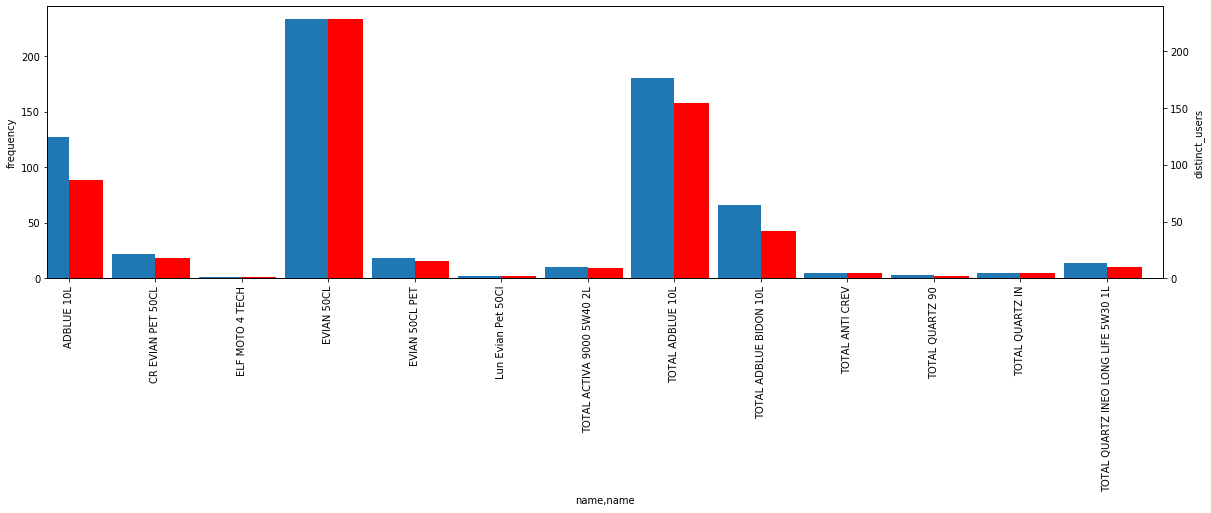

In [35]:
df.TRANSACTION_DATE = pd.to_datetime(df.TRANSACTION_DATE)
all_promo = df[(df.TRANSACTION_DATE>=promo_date_begin)&(df.TRANSACTION_DATE<= promo_date_end)]

import matplotlib.pyplot as plt 

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
stats_df.groupby("name")["name"].value_counts().plot.bar(figsize=(20,5),ax=ax, position=1)
stats_df.groupby("name")["CUST_ID"].nunique().plot.bar(color='red',ax=ax2, width=width, position=0)

# df.price.plot(kind='bar', color='blue', )

ax.set_ylabel('frequency')
ax2.set_ylabel('distinct_users')

plt.show()